In [1]:
import numpy as np
import pandas as pd
import argparse
import json
import pickle
import os
import numba
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow import keras as kr
import tensorflow.keras.optimizers as opt

#import model layers
from tensorflow.keras.layers import Layer,Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1_l2      
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#import QKeras as qkr
from qkeras import QDense, QConv2D, QActivation
import json

import ot
import uproot
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema

2023-01-09 19:25:25.603066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from load_utils import load_data, normalize, unnormalize

In [280]:
data_values, eta_values = load_data(infile = '/Users/physics/hep/ex/code/Ecoder/5Elinks_data.csv',nrows = 100000)

(100000, 48)


In [282]:
# measure TC occupancy
occupancy_all = np.count_nonzero(data_values,axis=1) # measure non-zero TCs (should be all)
occupancy_all_1MT = np.count_nonzero(data_values>35,axis=1) # measure TCs with charge > 35

# normalize input charge data
# rescaleInputToMax: normalizes charges to maximum charge in module
# sumlog2 (default): normalizes charges to 2**floor(log2(sum of charge in module)) where floor is the largest scalar integer: i.e. normalizes to MSB of the sum of charges (MSB here is the most significant bit)
# rescaleSum: normalizes charges to sum of charge in module
normdata,maxdata,sumdata = normalize(data_values.copy(),sumlog2=True)
maxdata = maxdata / 35. # normalize to units of transverse MIPs
sumdata = sumdata / 35. # normalize to units of transverse MIPs

In [283]:
networks_by_name = [
    {'name':'8x8_c8_S2_qK_RTL_emd_lphe',
     'label':'8x8_c[8]_S2_q_emd_lphe',
     'arr_key':'8x8',
     'isQK':True,
     'params':{
         'shape':(8,8,1),
         'loss':'',
         'CNN_layer_nodes':[8],
         'CNN_kernel_size':[3],
         'CNN_strides':[(2,2)],
        },
    }
]

In [284]:
def build_model():

    # select models to run
    
    m_to_run = ['8x8_c8_S2_qK_RTL_tele','8x8_c8_S2_qK_RTL_emd_lphe']
    models = [n for n in networks_by_name if n['name'] in m_to_run]

        
    nBits_encod = dict()
    nBits_encod  = {'total':  9, 'integer': 1,'keep_negative':0} # 0 to 2 range, 8 bit decimal 
    nBits_input  = {'total': 10, 'integer': 3, 'keep_negative':1}
    nBits_accum  = {'total': 11, 'integer': 3, 'keep_negative':1}
    nBits_weight = {'total':  5, 'integer': 1, 'keep_negative':1} # sign bit not included
    
    for m in models:
        if not 'nBits_encod' in m['params'].keys():
            m['params'].update({'nBits_encod':nBits_encod})
            m['params'].update({'nBits_input':nBits_input})
            m['params'].update({'nBits_accum':nBits_accum})
            m['params'].update({'nBits_weight':nBits_weight})
            
    for m in models:
        # print nbits for qkeras
        if m['isQK']:
            print('qKeras model weight {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_weight']))
            print('qKeras model input {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_input']))
            print('qKeras model accum {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_accum']))
            print('qKeras model encod {total}, {integer}, {keep_negative}'.format(**m['params']['nBits_encod']))
             
    return models

In [285]:
models = build_model()

qKeras model weight 5, 1, 1
qKeras model input 10, 3, 1
qKeras model accum 11, 3, 1
qKeras model encod 9, 1, 0


In [286]:
!pwd

/Users/physics/hep/ex/code/Ecoder/custom_training_3/custom_training_3


In [287]:
orig_dir = os.getcwd()
if not os.path.exists('custom_training_3'): os.mkdir('custom_training_3')
os.chdir('custom_training_3')

In [288]:
!pwd

/Users/physics/hep/ex/code/Ecoder/custom_training_3/custom_training_3/custom_training_3


In [289]:
class MaskLayer(Layer):
    def __init__(self,nFilter,arrMask):
        super(MaskLayer, self).__init__()
        self.nFilter = tf.constant(nFilter)
        self.arrayMask = np.array([arrMask])
        self.mask = tf.reshape(tf.stack(
                        tf.repeat(self.arrayMask,repeats=[nFilter],axis=0),axis=1),
                        shape=[-1])      
    def call(self, inputs):
        return tf.reshape(tf.boolean_mask(inputs,self.mask,axis=1),
                          shape=(tf.shape(inputs)[0],48*self.nFilter))
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'nFilter': self.nFilter.numpy(),
            'arrMask': self.arrayMask.tolist(),
        })
        return config

In [290]:
arrange =  np.array([28,29,30,31,0,4,8,12,
                     24,25,26,27,1,5,9,13,
                     20,21,22,23,2,6,10,14,
                     16,17,18,19,3,7,11,15,
                     47,43,39,35,35,34,33,32,
                     46,42,38,34,39,38,37,36,
                     45,41,37,33,43,42,41,40,
                     44,40,36,32,47,46,45,44])

arrMask= np.array([1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,])
    
calQMask=np.array([1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,])


In [291]:
def prepInput(normData):
    
    shape = (8,8,1)
    inputdata = normData[:,arrange]

    inputdata[:,arrMask==0]=0  #zeros out repeated entries

    shaped_data = inputdata.reshape(len(inputdata),shape[0],shape[1],shape[2])
    
    return shaped_data

In [292]:
remap_8x8 = [4, 12, 20, 28,  5, 13, 21, 29,  6, 14, 22, 30,  7, 15, 23, 31, 
             24, 25, 26, 27, 16, 17, 18, 19,  8,  9, 10, 11,  0,  1,  2,  3, 
             59, 51, 43, 35, 58, 50, 42, 34, 57, 49, 41, 33, 56, 48, 40, 32]

arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])



In [293]:
model_path='/Users/physics/hep/ex/code/Ecoder/ae_mse_lphe.h5'
emd_model = tf.keras.models.load_model(model_path)
emd_model.trainable = False

def map_881_to_443(x):
    y = tf.reshape(x, (-1, 64))
    y = tf.gather(y, remap_8x8, axis=1)
    y = tf.gather(y, arrange443, axis=1)
    y = tf.reshape(y, (-1, 4, 4, 3))
    return y

In [294]:
shaped_data = prepInput(normdata)

def split(shaped_data, validation_frac=0.2,randomize=False):
    N = round(len(shaped_data)*validation_frac)
    if randomize:
        val_index = np.random.choice(shaped_data.shape[0], N, replace=False) # randomly select 25% entries
        full_index = np.array(range(0,len(shaped_data))) # select the indices of the other 75%
        train_index = np.logical_not(np.in1d(full_index,val_index))

        val_input = shaped_data[val_index]
        train_input = shaped_data[train_index]
    else:
        val_input = shaped_data[:N]
        train_input = shaped_data[N:]
        val_index = np.arange(N)
        train_index = np.arange(len(shaped_data))[N:]

    print('Training shape')
    print(train_input.shape)
    print('Validation shape')
    print(val_input.shape)
    return val_input,train_input,val_index,train_index

val_input, train_input, val_ind, train_ind = split(shaped_data)

train_sum = sumdata[train_ind]
val_sum = sumdata[val_ind]

Training shape
(80000, 8, 8, 1)
Validation shape
(20000, 8, 8, 1)


In [295]:
encoded_dim = 16

CNN_layer_nodes   = [8]
CNN_kernel_size   = [3]
CNN_padding       = ['same']
CNN_strides       = [(2,2)]
CNN_pool          = [False]
Dense_layer_nodes = [] #does not include encoded layer
channels_first    = False

In [296]:
def emd_loss(y_true_cal,y_pred_cal):
    
    y_pred_443 = map_881_to_443(y_pred_cal)
    y_true_443 = map_881_to_443(y_true_cal)
    return emd_model([y_true_443, y_pred_443])

In [297]:
inputs = Input(shape=(8,8,1))

x = inputs

for i,n_nodes in enumerate(CNN_layer_nodes):

    x = Conv2D(n_nodes, CNN_kernel_size[i], activation='relu', strides=CNN_strides[i], padding=CNN_padding[i])(x)

shape = K.int_shape(x)

x = Flatten()(x)

encodedLayer = Dense(encoded_dim, activation='relu',name='encoded_vector')(x)


# Instantiate Encoder Model
encoder = Model(inputs, encodedLayer, name='encoder')

encoded_inputs = Input(shape=(encoded_dim,), name='decoder_input')

x = encoded_inputs

#decoder dense nodes

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i,n_nodes in enumerate(CNN_layer_nodes):

    x = Conv2DTranspose(n_nodes, CNN_kernel_size[i], activation='relu', strides=CNN_strides[i],padding=CNN_padding[i])(x)

x = Conv2DTranspose(filters=(8,8,1)[2],kernel_size=CNN_kernel_size[0],padding='same')(x)

outputs= Activation('sigmoid', name='decoder_output')(x)

decoder = Model(encoded_inputs, outputs, name='decoder')

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

In [298]:
autoencoder.compile(optimizer='adam', loss=emd_loss)

In [299]:
n_epochs=20

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = autoencoder.fit(train_input,
                          train_input,
                          sample_weight = np.square(train_sum),
                          epochs=n_epochs,
                          batch_size=50,
                          validation_data=(val_input,val_input),
                          callbacks=[es])

Epoch 1/20
1600/1600 [==============================] - 17s 10ms/step - loss: 1086.5653 - val_loss: 3.3486
Epoch 2/20
1600/1600 [==============================] - 16s 10ms/step - loss: 542.6600 - val_loss: 2.7112
Epoch 3/20
1600/1600 [==============================] - 16s 10ms/step - loss: 456.4640 - val_loss: 2.4413
Epoch 4/20
1600/1600 [==============================] - 16s 10ms/step - loss: 414.3969 - val_loss: 2.2515
Epoch 5/20
1600/1600 [==============================] - 16s 10ms/step - loss: 385.5162 - val_loss: 2.1082
Epoch 6/20
1600/1600 [==============================] - 16s 10ms/step - loss: 363.1803 - val_loss: 1.9845
Epoch 7/20
1600/1600 [==============================] - 16s 10ms/step - loss: 346.5132 - val_loss: 1.9471
Epoch 8/20
1600/1600 [==============================] - 16s 10ms/step - loss: 335.2032 - val_loss: 1.8693
Epoch 9/20
1600/1600 [==============================] - 19s 12ms/step - loss: 324.7178 - val_loss: 1.7761
Epoch 10/20
1600/1600 [======================

In [300]:
def plot_loss(history):
    plt.figure(figsize=(8,6))
    plt.yscale('log')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.savefig("history.pdf")
    plt.show()
    plt.close()
    plt.clf()
    return

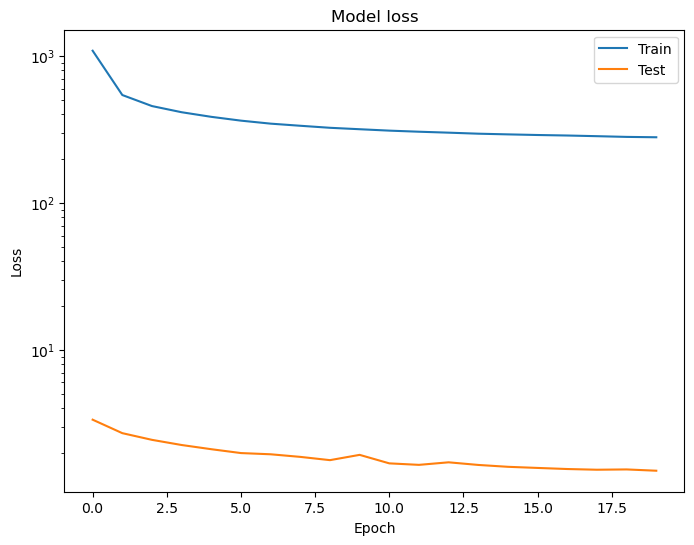

<Figure size 640x480 with 0 Axes>

In [301]:
plot_loss(history)

In [302]:
def invertArrange(arrange,arrMask=[],calQMask=[]):
    remap =[]
    hashmap = {}  ## cell:index mapping
    ##Valid arrange check
    if not np.all(np.unique(arrange)==np.arange(48)):
        raise ValueError("Found cell location with number > 48. Please check your arrange:",arrange)
    foundDuplicateCharge = False
    if len(arrMask)==0:
        if len(arrange)>len(np.unique(arrange)):
            foundDuplicateCharge=True
    else:
        if len(arrange[arrMask==1])>len(np.unique(arrange[arrMask==1])):
            foundDuplicateCharge=True

    if foundDuplicateCharge and len(calQMask)==0:
        raise ValueError("Found duplicated charge arrangement, but did not specify calQmask")  
    if len(calQMask)>0 and np.count_nonzero(calQMask)!=48:
        raise ValueError("calQmask must indicate 48 calQ ")  

    for i in range(len(arrange)):
        if len(arrMask)>0 :
            ## fill hashmap only if arrMask allows it
            if arrMask[i]==1:   
                if(foundDuplicateCharge):
                    ## fill hashmap only if calQMask allows it
                    if calQMask[i]==1: hashmap[arrange[i]]=i                    
                else:
                    hashmap[arrange[i]]=i                    
        else:
            hashmap[arrange[i]]=i
    ## Always map to 48 calQ orders
    for i in range(len(np.unique(arrange))):
        remap.append(hashmap[i])
    return np.array(remap)

## remap input/output of autoencoder into CALQs orders
def mapToCalQ(x):
    if len(arrange) > 0:
        remap   = invertArrange(arrange,arrMask,calQMask)
        if len(arrMask)>0:
            imgSize =(8,8,1)[0] *(8,8,1)[1]* (8,8,1)[2]
            x = x.reshape(len(x),imgSize)
            x[:,arrMask==0]=0 ## apply arrMask
            return x[:,remap]             ## map to calQ 
        else:
            return x.reshape(len(x),48)[:,remap]
    else:
        return x.reshape(len(x),48)


def predict(x):
    decoded_Q = predict(x)
    encoded_Q = self.encoder.predict(x)
    encoded_Q = np.reshape(encoded_Q, (len(encoded_Q), 16, 1))
    return x,decoded_Q, encoded_Q

In [303]:
history = autoencoder.history

In [304]:
with open('./history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

def save_models(autoencoder):
    from utils import graph
    
    name = 'weighted_emd'

    json_string = autoencoder.to_json()
    encoder = autoencoder.get_layer("encoder")
    decoder = autoencoder.get_layer("decoder")
    with open('./%s.json'%name,'w') as f:        f.write(autoencoder.to_json())
    with open('./%s.json'%("encoder_"+name),'w') as f:            f.write(encoder.to_json())
    with open('./%s.json'%("decoder_"+name),'w') as f:            f.write(decoder.to_json())
    autoencoder.save_weights('%s.hdf5'%name)
    encoder.save_weights('%s.hdf5'%("encoder_"+name))
    decoder.save_weights('%s.hdf5'%("decoder_"+name))
    graph.write_frozen_graph(encoder,'encoder_'+name+'.pb')
    graph.write_frozen_graph(encoder,'encoder_'+name+'.pb.ascii','./',True)
    graph.write_frozen_graph(decoder,'decoder_'+name+'.pb')
    graph.write_frozen_graph(decoder,'decoder_'+name+'.pb.ascii','./',True)

    graph.plot_weights(autoencoder)
    graph.plot_weights(encoder)
    graph.plot_weights(decoder)

save_models(autoencoder)   

2023-01-09 20:44:08.077754: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-01-09 20:44:08.077864: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-09 20:44:08.141518: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-01-09 20:44:08.141590: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-09 20:44:08.223774: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-01-09 20:44:08.223840: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-09 20:44:08.367640: I tensorflow/core/grappler/devices.c

1 encoder unique weights 72
2 decoder unique weights 2048
1 conv2d_33 unique weights 72
2 no weights
3 encoded_vector unique weights 2048
1 dense_33 unique weights 2048
2 no weights
3 conv2d_transpose_66 unique weights 576
4 conv2d_transpose_67 unique weights 72
5 no weights


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [314]:
cnn_deQ = autoencoder.predict(shaped_data)

3125/3125 [==============================] - 3s 1ms/step


In [315]:
# shape = (N,48) in CALQ order
input_calQ = mapToCalQ(shaped_data)
output_calQ = mapToCalQ(cnn_deQ)   # shape = (N,48) in CALQ order
print('inputQ shape')
print(input_calQ.shape)
print('inputcalQ shape')
print(output_calQ.shape)

inputQ shape
(100000, 48)
inputcalQ shape
(100000, 48)


In [307]:
val_max = maxdata[val_ind]
val_sum = sumdata[val_ind]
val_eta = eta_values[val_ind]

In [316]:
print('Restore normalization')

input_calQ =  unnormalize(input_calQ.copy(),sumdata)
output_calQ =  unnormalize(output_calQ.copy(),sumdata)

Restore normalization


In [309]:
from utils.metrics import emd

In [317]:
indices = range(0,(len(input_calQ)))
        
emd_values = np.array([emd(input_calQ[i],output_calQ[j]) for i, j in zip(indices,indices)])

In [318]:
import scipy

from scipy import stats, optimize, interpolate

(array([2.2030e+03, 1.5661e+04, 2.8088e+04, 2.8079e+04, 1.6764e+04,
        6.7910e+03, 2.0240e+03, 3.4300e+02, 4.1000e+01, 6.0000e+00]),
 array([0.24405026, 0.49172583, 0.7394014 , 0.98707697, 1.23475254,
        1.48242812, 1.73010369, 1.97777926, 2.22545483, 2.4731304 ,
        2.72080597]),
 <BarContainer object of 10 artists>)

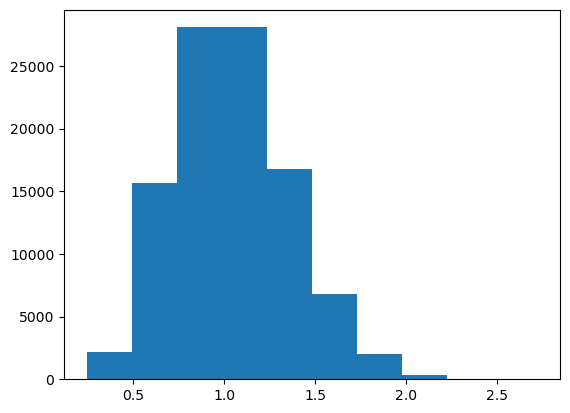

In [319]:
plt.hist(emd_values)

<ErrorbarContainer object of 3 artists>

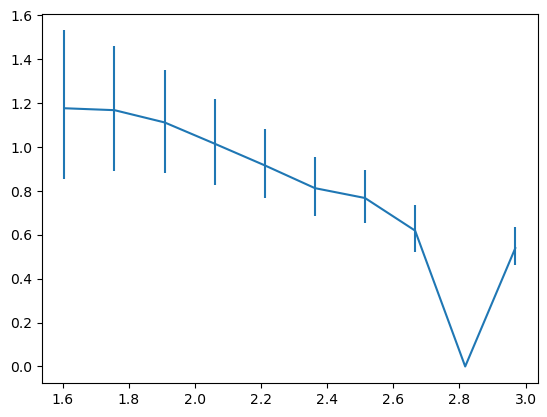

In [321]:
x=eta_values
y=emd_values

nbins=10
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie], label='emd v eta')

<ErrorbarContainer object of 3 artists>

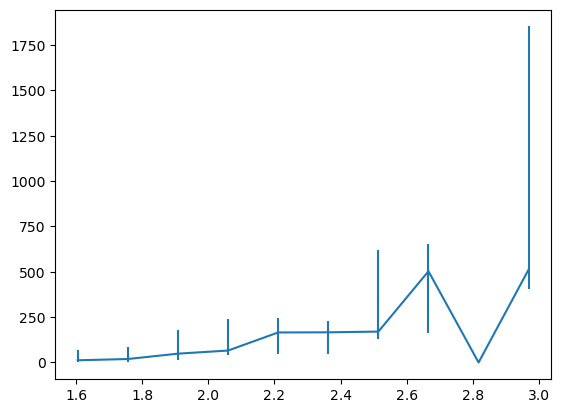

In [323]:
x=eta_values
y=emd_values*sumdata*sumdata

nbins=10
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie], label='emd v eta')

In [258]:
occupancy_0MT = np.count_nonzero(input_calQ,axis=1)

<ErrorbarContainer object of 3 artists>

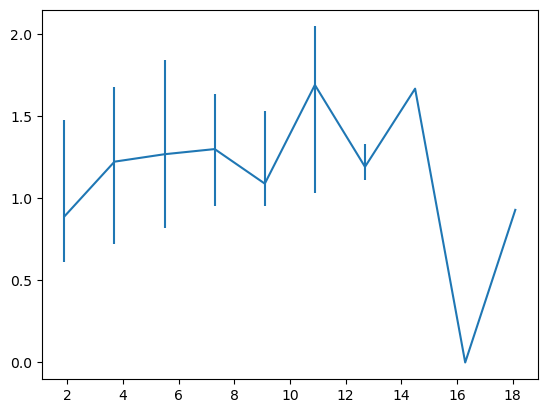

In [259]:
x=occupancy_0MT
y=emd_values

nbins=10
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie], label='emd v eta')